'''
Panagiotis Christakakis
'''

# **Node Embeddings - (1) Link Prediction & (2) Clustering**

## Libraries

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
# Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import itertools as it
from networkx.algorithms import community as cm
import matplotlib.pyplot as plt
from itertools import product
from node2vec import Node2Vec

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

## Functions

In [11]:
def model_to_dataframe(model, graph):
  emb = (
      pd.DataFrame(
          [model.wv.get_vector(str(n)) for n in graph.nodes()],
        index = graph.nodes
      )
  )
  return emb

# ------------------------------------------------------#

def partitioning(clusters_embedding_dfNUM):

  partition = [[],[],[]]

  for i in range(len(clusters_embedding_dfNUM['cluster'])):

      if int(clusters_embedding_dfNUM['cluster'][i]) == 0:
          partition[0].append(int(clusters_embedding_dfNUM['book_id'][i]))

      elif int(clusters_embedding_dfNUM['cluster'][i]) == 1:
          partition[1].append(int(clusters_embedding_dfNUM['book_id'][i]))

      else:
          partition[2].append(int(clusters_embedding_dfNUM['book_id'][i]))

  return partition

# ------------------------------------------------------#

def purityCalc(l,n,c):
    purity=0
    array=[]
    summation=[]
    maximum=[]
    for i in range(len(l)):
        array.append([l[i],n[i],c[i]])
    for j in array:
        summation.append(sum(j))
        maximum.append(max(j))
    purity=sum(maximum)/sum(summation)
    return purity

# ------------------------------------------------------#

def searchCommunity(dictionary,communities):
    l=[0 for i in range(len(communities))]
    c=[0 for i in range(len(communities))]
    n=[0 for i in range(len(communities))]
    for i in communities:
        for j in i:
            if dictionary[j]["value"]=="l":
                l[communities.index(i)]+=1
            elif dictionary[j]["value"]=="n":
                n[communities.index(i)]+=1
            elif dictionary[j]["value"]=="c":
                c[communities.index(i)]+=1
            else:
                continue

    purity=purityCalc(l,n,c)

    return purity

# ------------------------------------------------------#

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# ------------------------------------------------------#

def visualization(graph, dataframe):

  import pandas as pd
  import matplotlib.pyplot as plt
  from sklearn.manifold import TSNE
  import numpy as np

  # Variables needed for plotting
  embedding = np.array(dataframe.iloc[:,:-1].values.tolist())
  ids = dataframe.index.tolist()
  node_targets = [graph.nodes[int(node_id)]['value'] for node_id in ids]

  node_2d_emb = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embedding)

  label_map_cluster = {l: i for i, l in enumerate(np.unique(node_targets))}

  # Node color lists for visualization
  node_colours_cluster = []
  for target_1 in node_targets:
      if label_map_cluster[target_1] == 0:
          node_colours_cluster.append("red")
      elif label_map_cluster[target_1] == 1:
          node_colours_cluster.append("green")
      else:
          node_colours_cluster.append("blue")

  label_map_ground_truth = { l: i for i, l in enumerate(np.unique(dataframe['cluster']))}

  # Node color lists for visualization
  node_colours_ground_truth = []
  for target_2 in dataframe['cluster']:
      if label_map_ground_truth[target_2] == 0:
          node_colours_ground_truth.append("red")
      elif label_map_ground_truth[target_2] == 1:
          node_colours_ground_truth.append("green")
      else:
          node_colours_ground_truth.append("blue")

  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Plot the first scatter plot
  axes[0].scatter(node_2d_emb[:,0], node_2d_emb[:,1], c = node_colours_cluster, alpha = 0.5)
  axes[0].set_title("Cluster Visualization")

  # Plot the second scatter plot
  axes[1].scatter(node_2d_emb[:,0], node_2d_emb[:,1], c = node_colours_ground_truth, alpha = 1)
  axes[1].set_title("Ground Truth Visualization")

  # Add general title
  if get_df_name(dataframe) == "embedding_df_1":
    plt.suptitle("Visualization for Nove2Vec (q = 2 & p = 1)")
  elif get_df_name(dataframe) == "embedding_df_2":
    plt.suptitle("Visualization for Nove2Vec (q = 0.5 & p = 1)")
  elif get_df_name(dataframe) == "embedding_df_3":
    plt.suptitle("Visualization for Nove2Vec (q = 1 & p = 1)")

  # Display the plots
  plt.tight_layout()
  plt.show()

# ------------------------------------------------------#

def node2vecs_predictions(graph, embedding_model):

  '''
  The original author of the code is Vatsal P.
  Original code implementation can be found here:
  https://towardsdatascience.com/link-prediction-recommendation-engines-with-node2vec-c97c429351a8
  '''

  from sklearn.svm import SVC
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.naive_bayes import GaussianNB
  from sklearn.ensemble import GradientBoostingClassifier

  #create training data
  unique_nodes = list(graph.nodes())
  all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]

  # generate edge features for all pairs of nodes
  edge_features = [(embedding_model.wv.get_vector(str(i)) + embedding_model.wv.get_vector(str(j))) for i,j in all_possible_edges]

  # get current edges in the network
  edges = list(graph.edges())

  # create target list, 1 if the pair exists in the network, 0 otherwise
  is_con = [1 if e in edges else 0 for e in all_possible_edges]

  #train the model
  # get training and target data
  X = np.array(edge_features)
  y = is_con

  # train test split
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

  # Decision Tree
  clf_DT = DecisionTreeClassifier(max_depth=5)
  clf_DT.fit(x_train, y_train)
  # Model Performance
  y_pred_DT = clf_DT.predict(x_test)
  test_acc_DT = accuracy_score(y_test, y_pred_DT)
  print("Printing Metrics for Decision Tree Classification\n================================================")
  print("Testing Accuracy : ", test_acc_DT)
  print("Classification Report : ")
  print(classification_report(y_test, y_pred_DT))

  # Naive Bayes
  clf_NB = GaussianNB()
  clf_NB.fit(x_train, y_train)
  # Decision Tree
  clf_NB = DecisionTreeClassifier(max_depth=5)
  clf_NB.fit(x_train, y_train)
  # Model Performance
  y_pred_NB = clf_NB.predict(x_test)
  test_acc_NB = accuracy_score(y_test, y_pred_NB)
  print("Printing Metrics for Naive Bayes Classification\n================================================")
  print("Testing Accuracy : ", test_acc_NB)
  print("Classification Report : ")
  print(classification_report(y_test, y_pred_NB))

  # Gradient Boosting Classifier
  clf_GB = GradientBoostingClassifier()
  clf_GB.fit(x_train, y_train)
  # Model Performance
  y_pred_GB = clf_GB.predict(x_test)
  test_acc_GB = accuracy_score(y_test, y_pred_GB)
  print("Printing Metrics for Gradient Boosting Classifier\n================================================")
  print("Testing Accuracy : ", test_acc_GB)
  print("Classification Report : ")
  print(classification_report(y_test, y_pred_GB))

  # k-nearest neighbors Classifier
  clf_Kn = KNeighborsClassifier()
  clf_Kn.fit(x_train, y_train)
  # Model Performance
  y_pred_Kn = clf_Kn.predict(x_test)
  test_acc_Kn = accuracy_score(y_test, y_pred_Kn)
  print("Printing Metrics for k-nearest neighbors Classifier\n================================================")
  print("Testing Accuracy : ", test_acc_Kn)
  print("Classification Report : ")
  print(classification_report(y_test, y_pred_Kn))

  # SVM
  clf_SVM = SVC(C=0.025)
  clf_SVM.fit(x_train, y_train)
  # Model Performance
  y_pred_SVM = clf_SVM.predict(x_test)
  test_acc_SVM = accuracy_score(y_test, y_pred_SVM)
  print("Printing Metrics for SVM Classification\n================================================")
  print("Testing Accuracy : ", test_acc_SVM)
  print("Classification Report : ")
  print(classification_report(y_test, y_pred_SVM))

## Pre-processing

In [ ]:
H = nx.read_gml("./polbooks.gml", label='id')
G = nx.Graph(H).subgraph(max(nx.connected_components(nx.Graph(H)), key=len))

In [ ]:
print("The polbooks.gml subgraph of strongly connected component is size of:", len(G.nodes()), "nodes, and", len(G.edges()), "total edges.")

The polbooks.gml subgraph of strongly connected component is size of: 105 nodes, and 441 total edges.


## Metrics for Ground Truth

In [13]:
# The following code extracts the value of each node in order to
# create a list that includes all of them in order to measure the
# metrics needed. The exact same chunk of code was used inside the
# communityDetectionTechniques.

ground_truth = nx.get_node_attributes(G, 'value')

groundTruthComm_l = [node for node, value in ground_truth.items() if value == 'l']
groundTruthComm_n = [node for node, value in ground_truth.items() if value == 'n']
groundTruthComm_c = [node for node, value in ground_truth.items() if value == 'c']

groundTruthList = []
groundTruthList.append(groundTruthComm_l)
groundTruthList.append(groundTruthComm_n)
groundTruthList.append(groundTruthComm_c)

# Metrics for Ground Truth Communities
print("Printing Metrics for Ground Truth Communities \n=======================")

modularity_GT = nx.algorithms.community.modularity(G, groundTruthList)
print("Modularity is:", "{:.4f}".format(modularity_GT))

purity_GT = searchCommunity(G.nodes, groundTruthList)
print("Purity is:", "{:.4f}".format(purity_GT))

Printing Metrics for Ground Truth Communities 
Modularity is: 0.4149
Purity is: 1.0000


## Creation of Node2Vec embeddings & Dataframes

In [ ]:
embedding_1 = Node2Vec(G, dimensions = 64, num_walks = 40, workers = 4, q = 2, p = 1)
embedding_2 = Node2Vec(G, dimensions = 64, num_walks = 40, workers = 4, q = 0.5, p = 1)
embedding_3 = Node2Vec(G, dimensions = 64, num_walks = 40, workers = 4, q = 1, p = 1)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
embedding_model_1 = embedding_1.fit(window = 10, min_count = 1)
embedding_model_2 = embedding_2.fit(window = 10, min_count = 1)
embedding_model_3 = embedding_3.fit(window = 10, min_count = 1)

In [ ]:
embedding_df_1 = model_to_dataframe(embedding_model_1, G)
embedding_df_2 = model_to_dataframe(embedding_model_2, G)
embedding_df_3 = model_to_dataframe(embedding_model_3, G)

embedding_df_1.index.name = 'book_id'
embedding_df_2.index.name = 'book_id'
embedding_df_3.index.name = 'book_id'

print("Created Dataframes look like this:")
print(embedding_df_3)

Created Dataframes look like this:
               0         1         2         3         4         5         6   \
book_id                                                                         
0        0.214968 -0.323092  0.180528  0.122254  0.302057 -0.172102  0.026010   
1        0.218695 -0.057395  0.219408  0.041948  0.395311 -0.085582  0.063945   
2        0.290005 -0.075244  0.281484  0.300179  0.336700  0.078769  0.246411   
3        0.273315 -0.189131  0.309162  0.033976  0.137186  0.061870  0.214263   
4       -0.048836  0.079245 -0.015926  0.069419  0.465965 -0.278102 -0.084410   
...           ...       ...       ...       ...       ...       ...       ...   
100      0.084393 -0.249120  0.237311 -0.041499 -0.079344 -0.379502 -0.152211   
101      0.009476 -0.131380  0.313995 -0.223317 -0.071184 -0.233511  0.035170   
102     -0.134254 -0.165633  0.102453 -0.139726  0.000598 -0.253049  0.167760   
103     -0.206374 -0.129079  0.134142  0.344840 -0.134203  0.087917 -0.087

# **(1)** Node Embeddings - Link Prediction

Model Performance

### Metrics for Node2Vec (q = 2 & p = 1)

In [ ]:
node2vecs_predictions(G, embedding_model_1)

Printing Metrics for Decision Tree Classification
Testing Accuracy :  0.9489117291414753
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3176
           1       0.05      0.02      0.02       132

    accuracy                           0.95      3308
   macro avg       0.50      0.50      0.50      3308
weighted avg       0.92      0.95      0.94      3308

Printing Metrics for Naive Bayes Classification
Testing Accuracy :  0.9489117291414753
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3176
           1       0.05      0.02      0.02       132

    accuracy                           0.95      3308
   macro avg       0.50      0.50      0.50      3308
weighted avg       0.92      0.95      0.94      3308

Printing Metrics for Gradient Boosting Classifier
Testing Accuracy :  0.9452841596130592
Classification Report : 
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Metrics for Node2Vec (q = 0.5 & p = 1)

In [ ]:
node2vecs_predictions(G, embedding_model_2)

Printing Metrics for Decision Tree Classification
Testing Accuracy :  0.9558645707376058
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3170
           1       0.10      0.01      0.01       138

    accuracy                           0.96      3308
   macro avg       0.53      0.50      0.50      3308
weighted avg       0.92      0.96      0.94      3308

Printing Metrics for Naive Bayes Classification
Testing Accuracy :  0.9558645707376058
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3170
           1       0.10      0.01      0.01       138

    accuracy                           0.96      3308
   macro avg       0.53      0.50      0.50      3308
weighted avg       0.92      0.96      0.94      3308

Printing Metrics for Gradient Boosting Classifier
Testing Accuracy :  0.9461910519951633
Classification Report : 
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Metrics for Node2Vec (q = 1 & p = 1)

In [ ]:
node2vecs_predictions(G, embedding_model_3)

Printing Metrics for Decision Tree Classification
Testing Accuracy :  0.9582829504232164
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3184
           1       0.11      0.02      0.03       124

    accuracy                           0.96      3308
   macro avg       0.54      0.51      0.50      3308
weighted avg       0.93      0.96      0.94      3308

Printing Metrics for Naive Bayes Classification
Testing Accuracy :  0.9582829504232164
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3184
           1       0.06      0.01      0.01       124

    accuracy                           0.96      3308
   macro avg       0.51      0.50      0.50      3308
weighted avg       0.93      0.96      0.94      3308

Printing Metrics for Gradient Boosting Classifier
Testing Accuracy :  0.9501209189842805
Classification Report : 
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **(2)** Node Embeddings - Clustering

### Embeddings Clustering

In [ ]:
kmeans_embedding_1 = KMeans(n_clusters=3)
kmeans_embedding_2 = KMeans(n_clusters=3)
kmeans_embedding_3 = KMeans(n_clusters=3)

kmeans_embedding_1.fit(embedding_df_1)
kmeans_embedding_2.fit(embedding_df_2)
kmeans_embedding_3.fit(embedding_df_3)

labels_1 = kmeans_embedding_1.predict(embedding_df_1)
labels_2 = kmeans_embedding_2.predict(embedding_df_2)
labels_3 = kmeans_embedding_3.predict(embedding_df_3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
embedding_df_1['cluster'] = labels_1
embedding_df_2['cluster'] = labels_2
embedding_df_3['cluster'] = labels_3

clusters_embedding_df1 = embedding_df_1['cluster']
clusters_embedding_df2 = embedding_df_2['cluster']
clusters_embedding_df3 = embedding_df_3['cluster']

clusters_embedding_df1 = embedding_df_1.reset_index()[['book_id','cluster']]
clusters_embedding_df2 = embedding_df_2.reset_index()[['book_id','cluster']]
clusters_embedding_df3 = embedding_df_3.reset_index()[['book_id','cluster']]

print("Created Clusters Dataframes look like this:")
print(clusters_embedding_df3)

Created Clusters Dataframes look like this:
     book_id  cluster
0          0        0
1          1        0
2          2        0
3          3        0
4          4        0
..       ...      ...
100      100        2
101      101        2
102      102        2
103      103        1
104      104        1

[105 rows x 2 columns]


In [ ]:
partitioning_1 = partitioning(clusters_embedding_df1)
partitioning_2 = partitioning(clusters_embedding_df2)
partitioning_3 = partitioning(clusters_embedding_df3)

### Clustering Results

In [ ]:
# Metrics for Node2Vec (q = 2 & p = 1)
print("Printing Metrics for Node2Vec with q = 2 & p = 1\n================================================")

modularity_A = nx.algorithms.community.modularity(G, partitioning_1)
print("Modularity is:", "{:.4f}".format(modularity_A))

purity_A = searchCommunity(G.nodes, partitioning_1)
print("Purity is:", "{:.4f}".format(purity_A))


# Metrics for Node2Vec (q = 0.5 & p = 1)
print("\nPrinting Metrics for Node2Vec with q = 0.5 & p = 1\n==================================================")

modularity_B = nx.algorithms.community.modularity(G, partitioning_2)
print("Modularity is:", "{:.4f}".format(modularity_B))

purity_B = searchCommunity(G.nodes, partitioning_2)
print("Purity is:", "{:.4f}".format(purity_B))


# Metrics for Node2Vec (q = 1 & p = 1)
print("\nPrinting Metrics for Node2Vec with q = 1 & p = 1\n================================================")

modularity_C = nx.algorithms.community.modularity(G, partitioning_3)
print("Modularity is:", "{:.4f}".format(modularity_C))

purity_C = searchCommunity(G.nodes, partitioning_3)
print("Purity is:", "{:.4f}".format(purity_C))

Printing Metrics for Node2Vec with q = 2 & p = 1
Modularity is: 0.5017
Purity is: 0.8476

Printing Metrics for Node2Vec with q = 0.5 & p = 1
Modularity is: 0.4986
Purity is: 0.8476

Printing Metrics for Node2Vec with q = 1 & p = 1
Modularity is: 0.5017
Purity is: 0.8476


### Clustering Visualization

#### Node2Vec (q = 2 & p = 1)

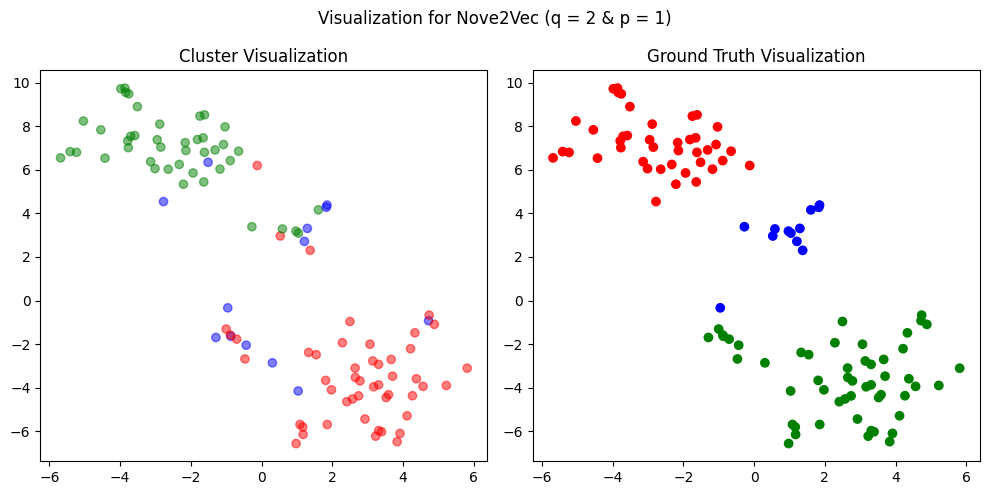

In [ ]:
visualization(G, embedding_df_1)

#### Node2Vec (q = 0.5 & p = 1)

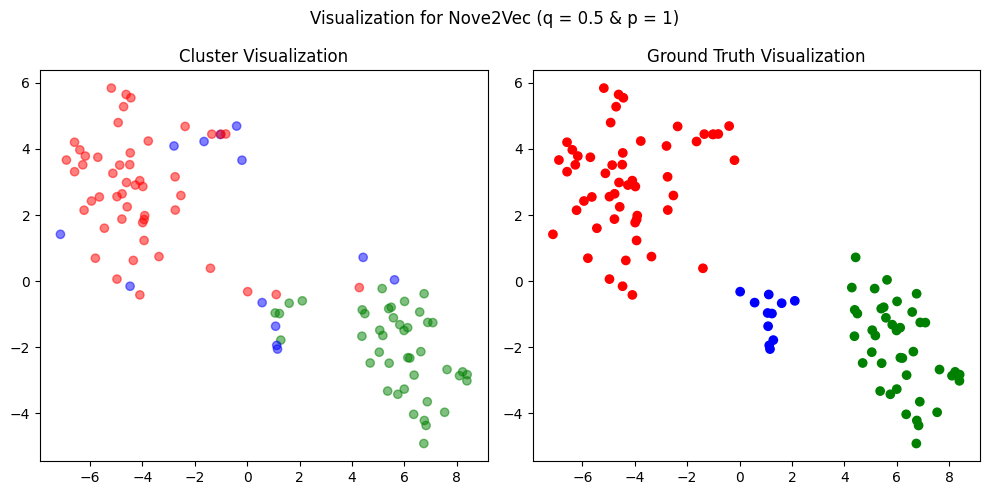

In [ ]:
visualization(G, embedding_df_2)

#### Node2Vec (q = 1 & p = 1)

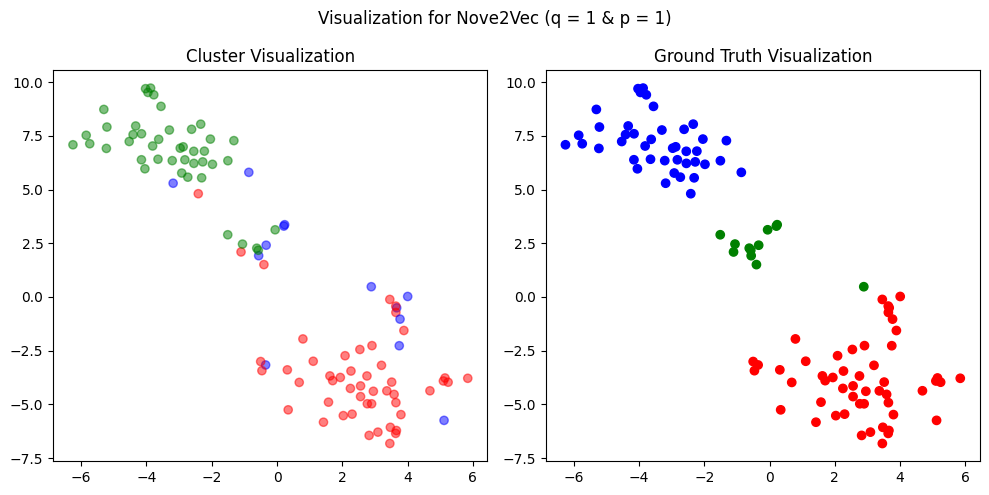

In [ ]:
visualization(G, embedding_df_3)